## Dice-20 game

In this notebook, we implement a value iteration algorithm to find the optimal policy to maximize the win in the "Dice 20 game".

The player holds a 20-faced dice, whose faces are numbered from $1$ to $20$. Each turn the player can:

- take an amount of money corresponding to the upper face of the current dice

- roll the dice without picking any reward

The game has a duration of 20 turns and at round 1 the dice shows one of its faces in $1,...,20$.

Which stategy is optimal to maximize the win?

In [1]:
# simple imports
import numpy as np
import pandas as pd
import time

In [2]:
# define random seed
np.random.seed(int(time.time()))

# define a class to play the game
class Game:
    def __init__(self, alpha=0.5, gamma=1, epsilon=0.05):
        self.dice = np.random.randint(1,21)
        self.t = 0
        # define Q and its last row, which will always be the current dice value
        self.Q = np.zeros((20,20,2))
        self.Q[:,19,0] = np.array([n for n in range(1, 21)])
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.rand_float = np.random.rand(20)
        self.delta_q = []
        
    def reset(self):
        self.dice = np.random.randint(1,21)
        self.t = 0
        self.rand_float = np.random.rand(20)
        
    def compute_policy(self):
        return np.argmax(self.Q, axis=2)
    
    def play_turn(self):
        # implement an epsilon-greedy policy
        # with a probability = 1-epsilon go greedy
        # else action is non-greedy (aid exploration)
        if self.rand_float[self.t] <= 1-self.epsilon:
            action = np.argmax(self.Q[self.dice-1, self.t])
        else:
            action = 1-np.argmax(self.Q[self.dice-1, self.t])
            
        # kkep the dice as it is and take reward
        if action == 0:
            r = self.dice
            self.Q[self.dice-1, self.t, action] = r + self.gamma * self.Q[self.dice-1, self.t+1, np.argmax(self.Q[self.dice-1, self.t+1])]
        # else throw the dice
        else:
            r = 0
            self.dice = np.random.randint(1,21)
            self.Q[self.dice-1, self.t, action] = r + self.gamma * np.mean(np.max(self.Q, axis=2)[:,self.t+1])          
        self.t += 1

    def play_turn_TD(self):
        # implement an epsilon-greedy policy
        # with a probability = 1-epsilon go greedy
        # else action is non-greedy (aid exploration)
        if self.rand_float[self.t] <= 1-self.epsilon:
            action = np.argmax(self.Q[self.dice-1, self.t])
        else:
            action = 1-np.argmax(self.Q[self.dice-1, self.t])
            
        # kkep the dice as it is and take reward
        if action == 0:
            r = self.dice
            self.Q[self.dice-1, self.t, action] = self.Q[self.dice-1, self.t, action] * (1 - self.alpha) + \
                                                    self.alpha * ( r + self.gamma * self.Q[self.dice-1, self.t+1, np.argmax(self.Q[self.dice-1, self.t+1])] )
        # else throw the dice
        else:
            r = 0
            self.dice = np.random.randint(1,21)
            self.Q[self.dice-1, self.t, action] = self.Q[self.dice-1, self.t, action] * (1 - self.alpha) + \
                                                    self.alpha * ( r + self.gamma * np.mean(np.max(self.Q, axis=2)[:,self.t+1]) )
        self.t+=1
    
    def play_game(self, repeat=100):
        start_Q = self.Q.copy()
        for i in range(repeat):
            for j in range(0, 20-1):
                self.play_turn()
            self.reset()
        end_Q = self.Q
        self.delta_q.append(np.sqrt(np.sum((end_Q-start_Q)**2)))

    def play_game_TD(self, repeat=100):
        start_Q = self.Q.copy()
        for i in range(repeat):
            for j in range(0, 20-1):
                self.play_turn_TD()
            self.reset()
        end_Q = self.Q
        self.delta_q.append(np.sqrt(np.sum((end_Q-start_Q)**2)))

In [3]:
# define a game object
game = Game()

In [10]:
# play a hundred times 100 games to update the policy
for i in range(300):
    game.play_game()
game.reset()

In [5]:
# import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

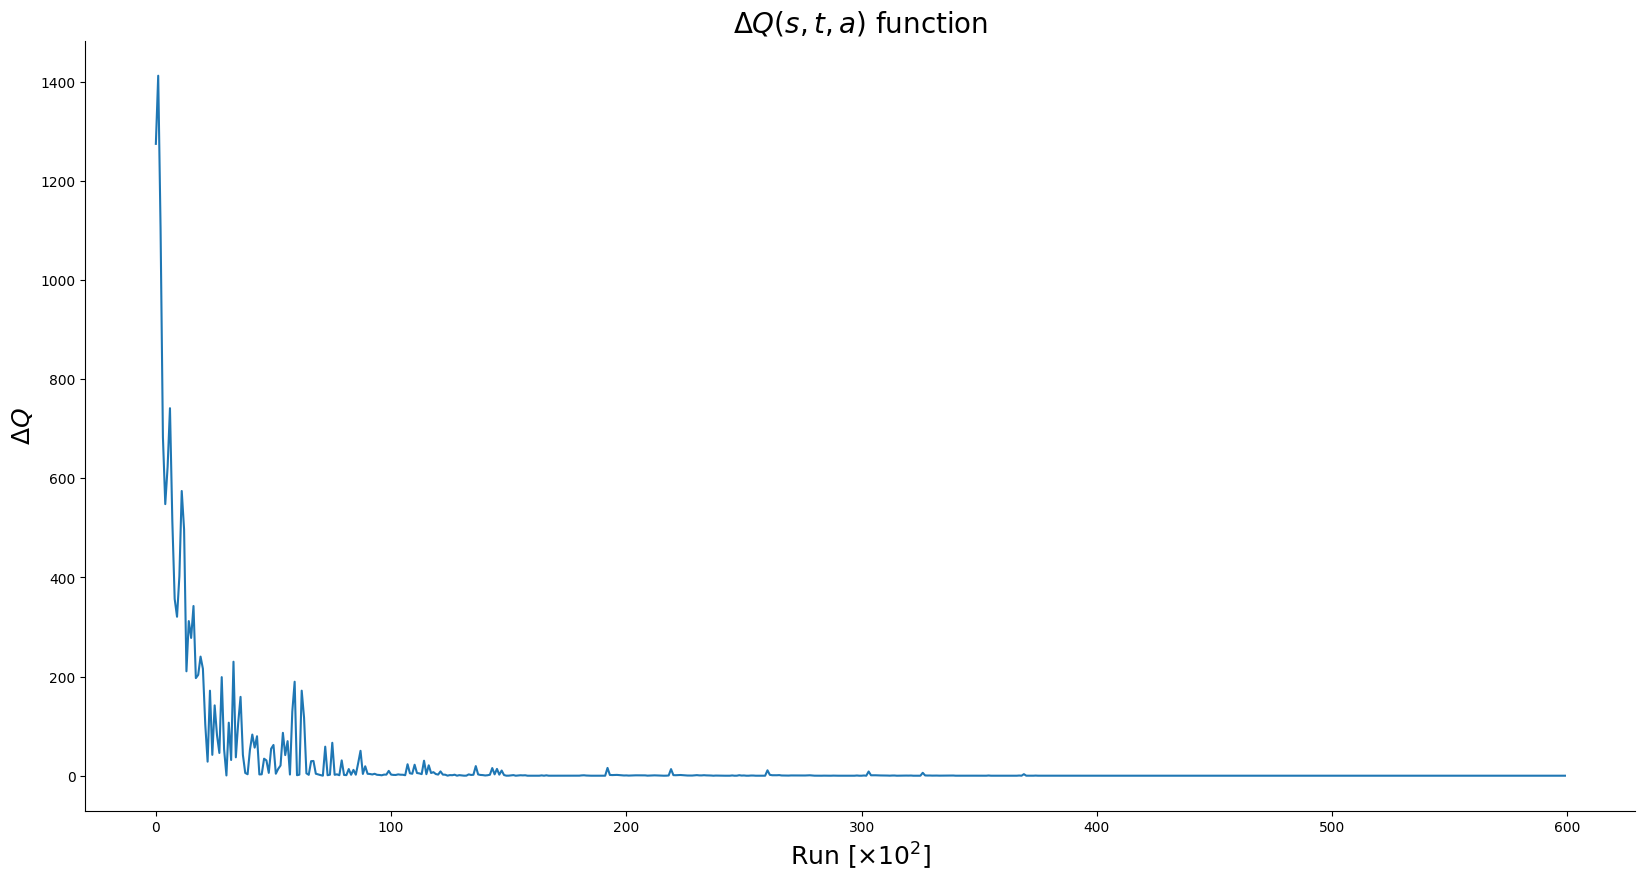

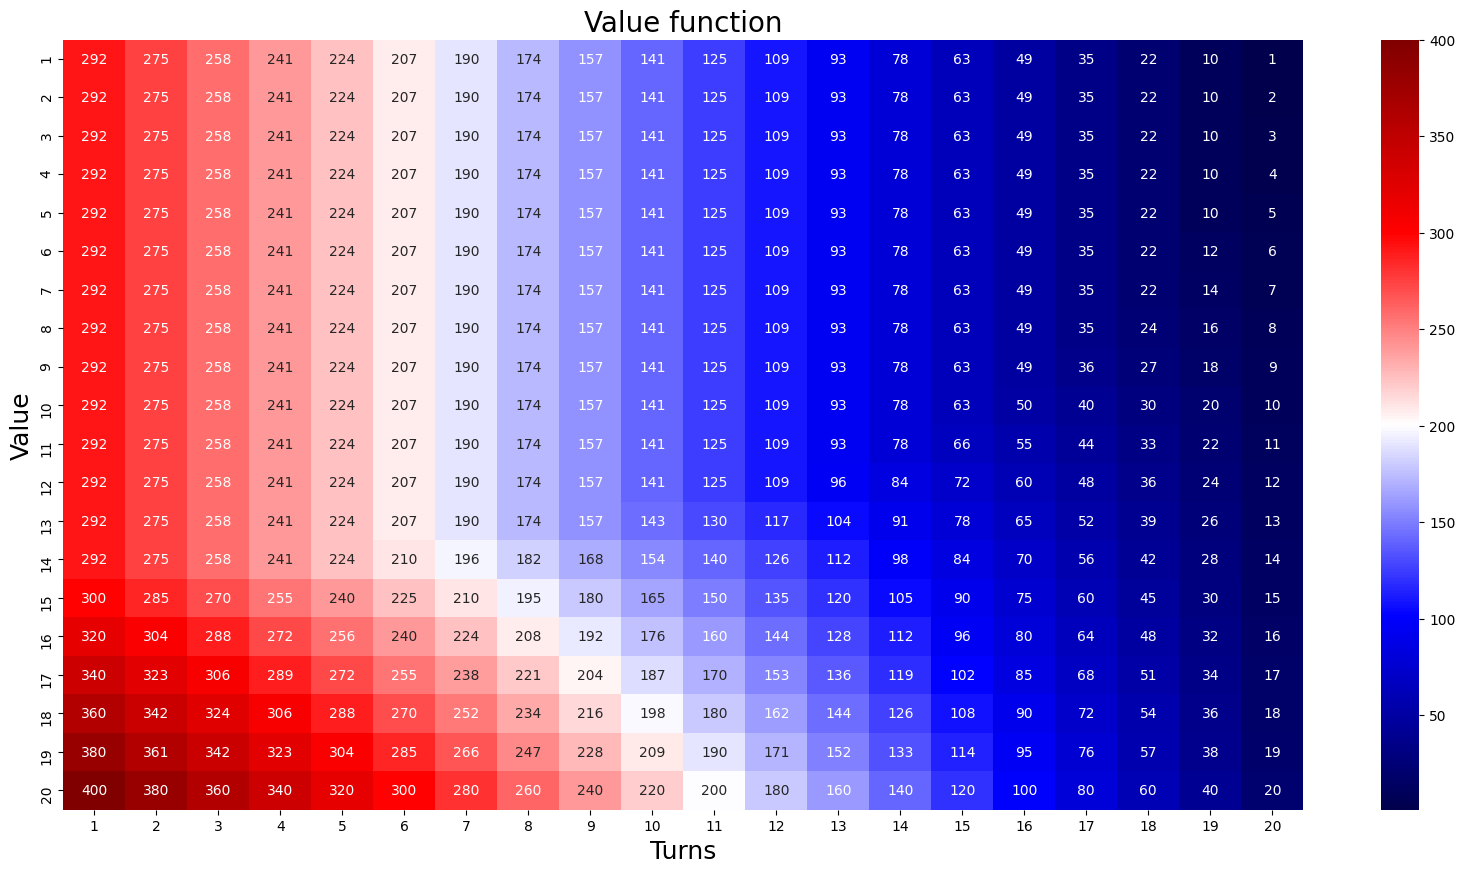

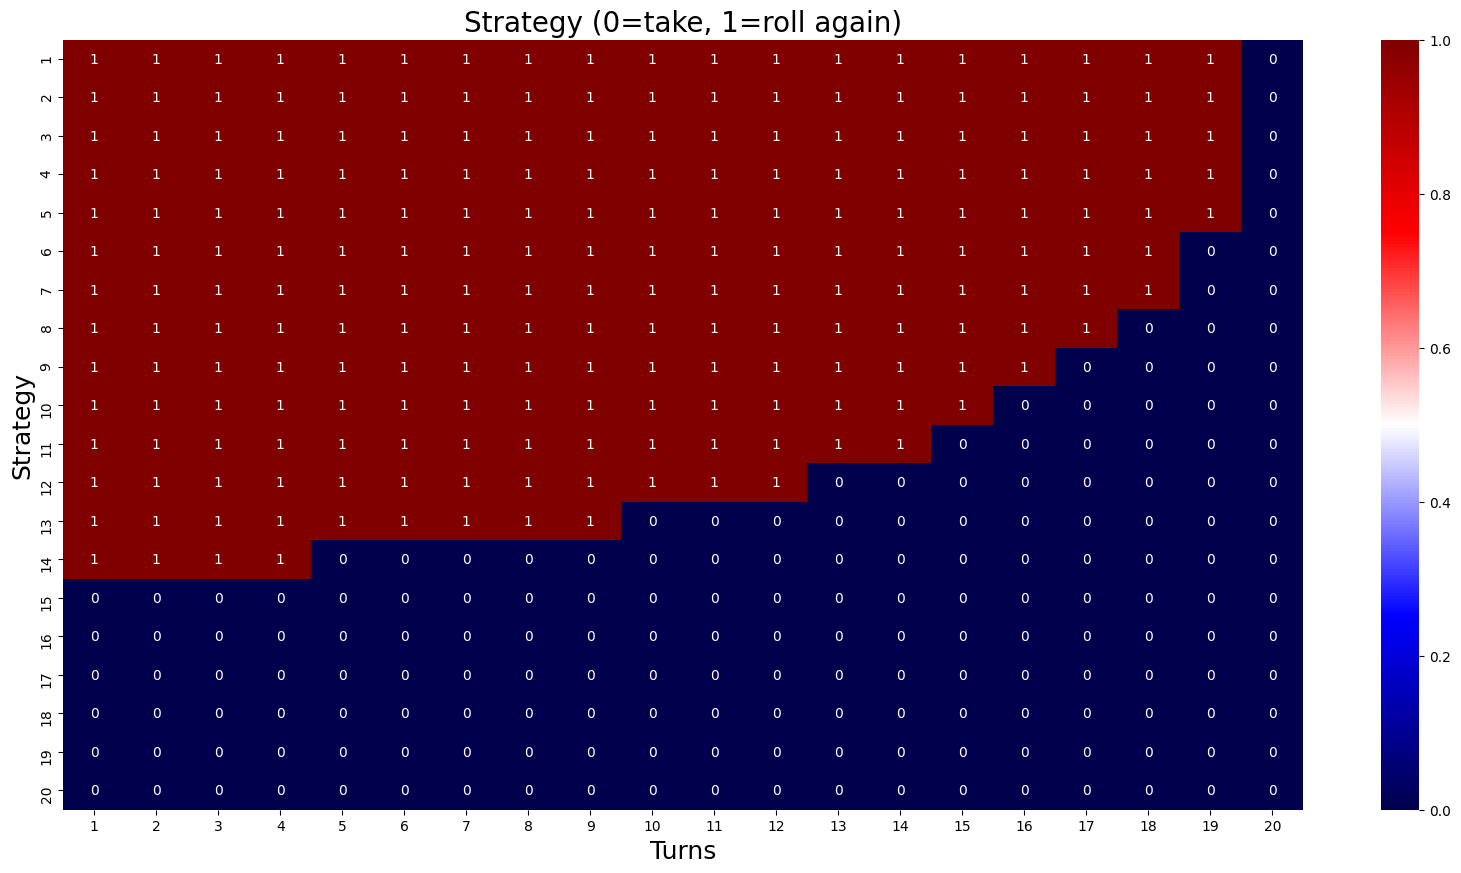

In [16]:
# plot functions
fig, ax = plt.subplots(figsize=(20,10))
plt.title(r'$\Delta Q(s,t,a)$ function', fontsize=20)
plt.plot(game.delta_q)
plt.ylabel(r'$\Delta Q$', fontsize=18)
plt.xlabel(r'Run [$\times 10^2$]', fontsize=18)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot()

# plot 2 -> value function
fig, ax = plt.subplots(figsize=(20,10))
plt.title(r'Value function', fontsize=20)
sns.heatmap(pd.DataFrame(np.round(np.max(game.Q, axis=2), 0),
                          index=[n for n in range(1,21)],
                          columns=[n for n in range(1,21)]), annot=True, cbar=True, fmt='g', cmap='seismic')
plt.xlabel(r'Turns', fontsize=18)
plt.ylabel(r'Value', fontsize=18)
plt.show()

# plot 3 -> strategy
fig, ax = plt.subplots(figsize=(20,10))
plt.title(r'Strategy (0=take, 1=roll again)', fontsize=20)
sns.heatmap(pd.DataFrame(np.argmax(game.Q, axis=2),
                        index=[n for n in range(1, 21)],
                        columns=[n for n in range(1, 21)]), annot=True, cbar=True, fmt='g', cmap='seismic')
plt.xlabel(r'Turns', fontsize=18)
plt.ylabel(r'Strategy', fontsize=18)
plt.show()

## TD learning

We now proceed implementing an online TD algorithm to the same problem

In [7]:
td_game = Game()

In [8]:
# play a hundred times 100 games to update the policy
for i in range(300):
    td_game.play_game_TD()
td_game.reset()

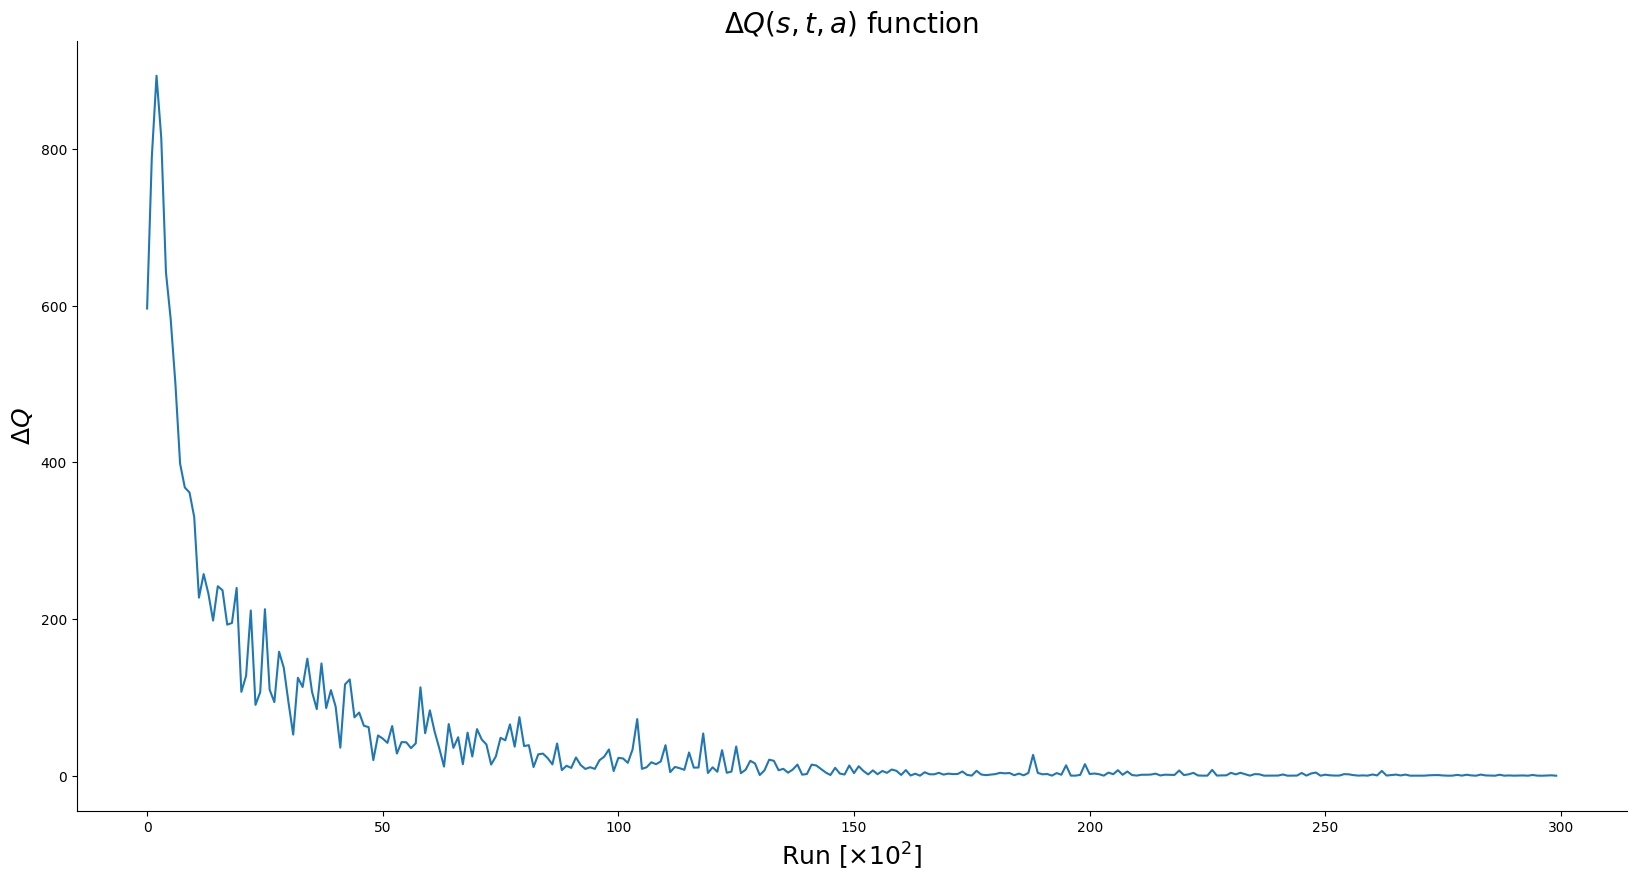

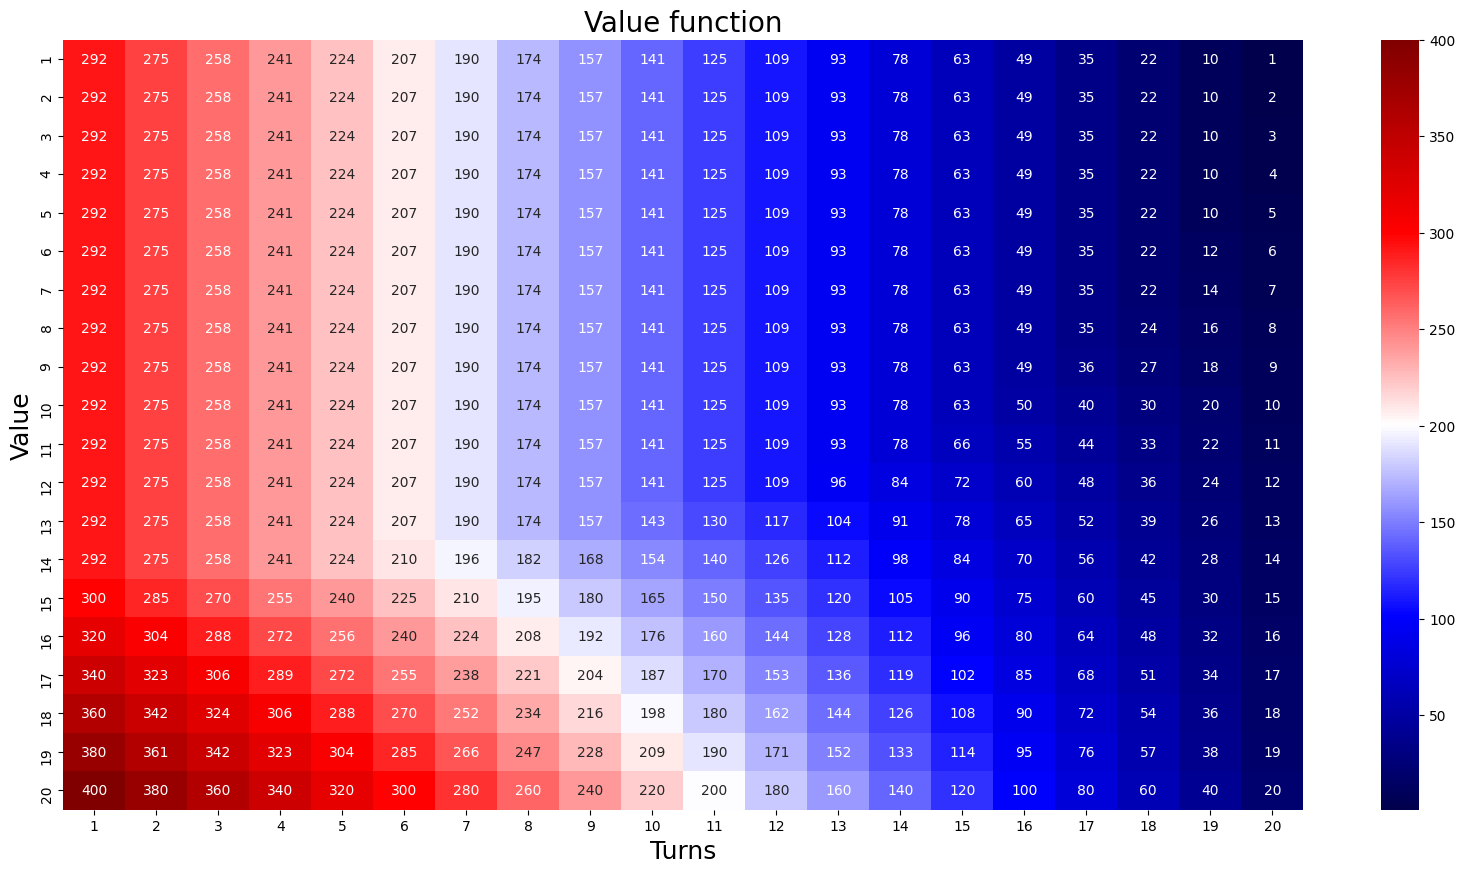

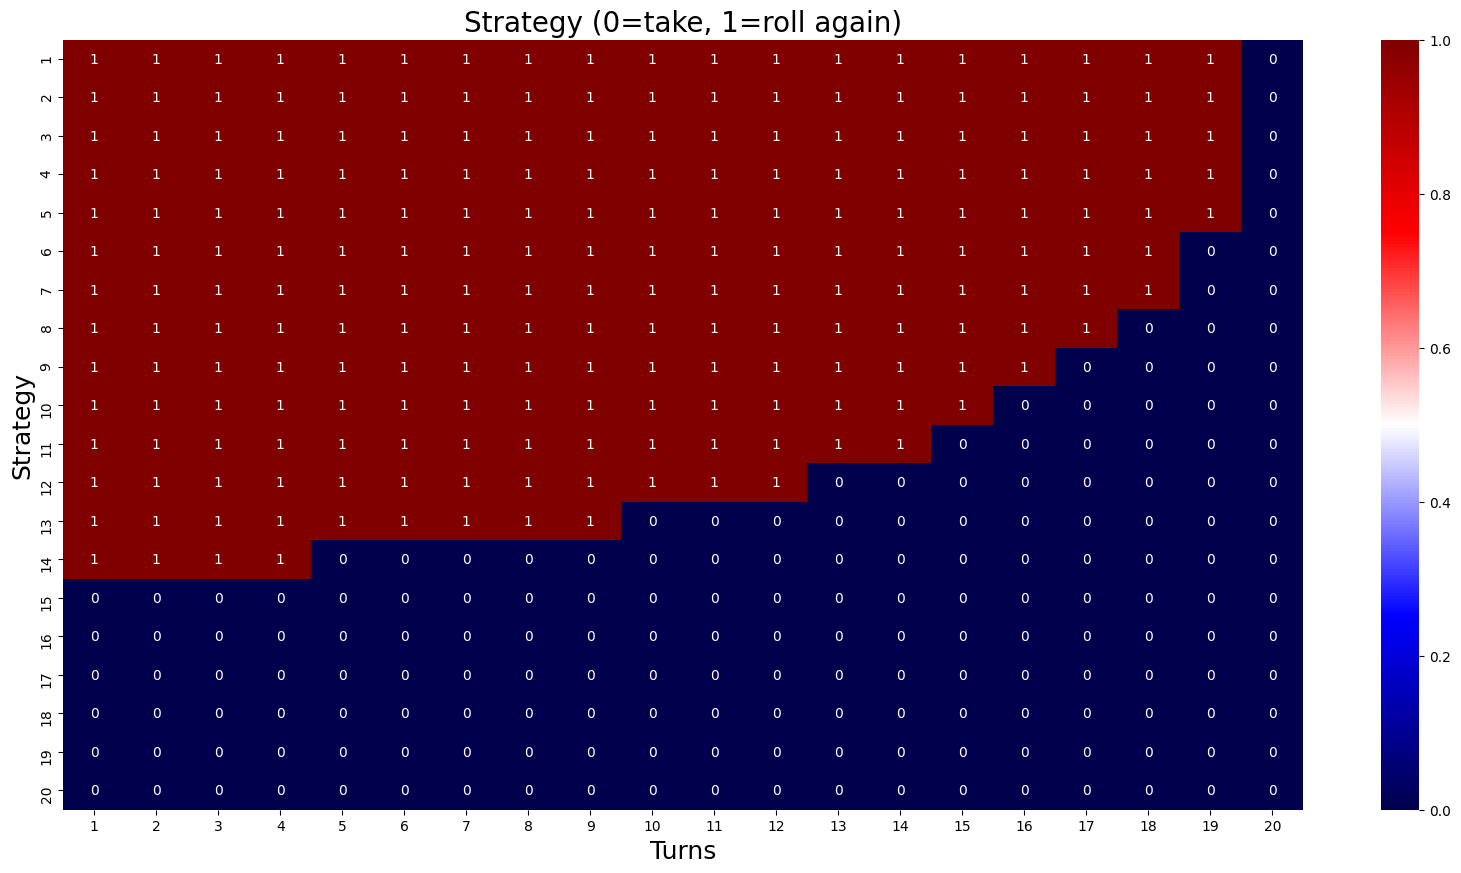

In [17]:
# plot functions
fig, ax = plt.subplots(figsize=(20,10))
plt.title(r'$ \Delta Q(s,t,a)$ function', fontsize=20)
plt.plot(td_game.delta_q)
plt.ylabel(r'$\Delta Q$', fontsize=18)
plt.xlabel(r'Run [$\times 10^2$]', fontsize=18)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot()

# plot 2 -> value function
fig, ax = plt.subplots(figsize=(20,10))
plt.title(r'Value function', fontsize=20)
sns.heatmap(pd.DataFrame(np.round(np.max(td_game.Q, axis=2), 0),
                          index=[n for n in range(1,21)],
                          columns=[n for n in range(1,21)]), annot=True, cbar=True, fmt='g', cmap='seismic')
plt.xlabel(r'Turns', fontsize=18)
plt.ylabel(r'Value', fontsize=18)
plt.show()

# plot 3 -> strategy
fig, ax = plt.subplots(figsize=(20,10))
plt.title(r'Strategy (0=take, 1=roll again)', fontsize=20)
sns.heatmap(pd.DataFrame(np.argmax(td_game.Q, axis=2),
                        index=[n for n in range(1, 21)],
                        columns=[n for n in range(1, 21)]), annot=True, cbar=True, fmt='g', cmap='seismic')
plt.xlabel(r'Turns', fontsize=18)
plt.ylabel(r'Strategy', fontsize=18)
plt.show()